In [41]:
import json
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import regex as re
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt

import datetime
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [330]:
# 데이터 생성, 처리
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

def train_test_result(dir, stock, variable, window_size):
    #score data 뽑기
    score = pd.read_csv(dir)
    score.columns = ["Date", "Score"]
    
    #price data 뽑기
    price_data = yf.download([stock],start = '2017-01-01', end = "2022-05-01")
    price_data = price_data.reset_index()
    
    first_data = yf.download([stock],start = '2016-12-30', end = '2017-01-01')
    
    #Date를 datetime형식으로 변경
    score.Date = score.Date.apply(lambda x: time_conversion(x))
    
    #price data와 score data 결합
    price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","Open","Score"]]

    #뉴스가 없는 날은 즉, score가 없는 날은 중립의 의미로 0으로 처리
    price_data.Score[price_data.Score.isnull()]=0

    #전날 종가의 영향을 받으므로 전날 종가 변수를 생성
    price_data["before_close"] = 0
    price_data = price_data.reset_index(drop=True)
    for i in range(len(price_data)-1):
        price_data.before_close[i+1] = price_data.Close[i]
    
    price_data.before_close[0] = first_data["Close"][0]

    # minmaxscaler 사용
    price_data.columns = ["Close","Open","Score","before_close"]
    
    x = price_data[variable]
    y = price_data[["Close"]]
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    x = pd.DataFrame(scaler_x.fit_transform(x))
    y = pd.DataFrame(scaler_y.fit_transform(y))
    
    x.columns = variable
    y.columns = ["Close"]

    train_index = int(len(x)*0.7)

    train_x = x.iloc[0:train_index]
    test_x = x.iloc[train_index:len(x)]

    train_y = y.iloc[0:train_index]
    test_y = y.iloc[train_index:len(y)]

    train_x = train_x.to_numpy().reshape(train_x.shape[0],1,train_x.shape[1])
    train_y = train_y.to_numpy().reshape(train_y.shape[0],train_y.shape[1])
    test_x = test_x.to_numpy().reshape(test_x.shape[0],1,test_x.shape[1])
    test_y = test_y.to_numpy().reshape(test_y.shape[0],test_y.shape[1])
    
    #window size에 맞게 데이터 설정
    x = np.zeros(shape=(train_x.shape[0]-window_size+1,window_size,x.shape[1]))
    for i in range(train_x.shape[0]-window_size+1):
        x[i]=np.vstack((train_x[i:i+window_size]))

    y = train_y[window_size-1:train_x.shape[0]]

    x_t = np.zeros(shape=(test_x.shape[0]-window_size+1,window_size,x.shape[2]))
    for i in range(test_x.shape[0]-window_size+1):
        x_t[i]=np.vstack((test_x[i:i+window_size]))
    
    y_t = test_y[window_size-1:test_x.shape[0]]
    
    return x, y, x_t, y_t


# 1. SVR

`-` The optimization of share price prediction model based on support vector machine 사용

`-` 위 논문에서 SVR이 kernel = 'rbf', C=102.2, gamma = 0.0625, epsilon= 0.01 일 때 최적화 되었다고 소개

`-` 문제 : 하루 전 데이터의 양상을 거의 동일하게 따라함. 즉, t-1일 주가 데이터를 t일의 예측데이터로 사용한 것과 비슷

In [256]:
import warnings
warnings.filterwarnings('ignore')


# price data, window = 1
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [44]:

x = x.reshape(len(x),window_size*len(variable))
y = y.reshape(len(y),1)
x_t = x_t.reshape(len(x_t),window_size*len(variable))
y_t = y_t.reshape(len(y_t),1)

model = SVR(kernel = 'rbf', C=102.2, gamma = 0.0625, epsilon= 0.01)
model.fit(x, y)
    
#예측값
svr_pred = np.reshape(model.predict(x_t),(len(model.predict(x_t)),1))
    
svr_mae = mean_absolute_error(y_t, svr_pred)
svr_mse = mean_squared_error(y_t, svr_pred)
svr_rmse = np.sqrt(mean_squared_error(y_t, svr_pred))

In [326]:
svr_rmse, svr_mse, svr_mae

(0.020378063482241828, 0.0004152654712862779, 0.016794553553055484)

# 2. ARIMA

`-` stock price prediction using BERT and GAN 사용

`-` 메일을 했으나 답이오지않아 정확히 카피는 불가하여 closing price와 arima모형만을 가져와 실습

`-` ARIMA(4,1,0) 사용

`-` 문제 : 하루 전 데이터의 양상을 거의 동일하게 따라함. 즉, t-1일 주가 데이터를 t일의 예측데이터로 사용한 것과 비슷

In [331]:
import warnings
warnings.filterwarnings('ignore')


# price data, window = 1
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [332]:
x = x.reshape(len(x),window_size*len(variable))
y = y.reshape(len(y),1)
x_t = x_t.reshape(len(x_t),window_size*len(variable))
y_t = y_t.reshape(len(y_t),1)

train = pd.DataFrame(x)
test = pd.DataFrame(x_t)

# 데이터프레임 펴주기
train = train.squeeze()
test = test.squeeze()

# 주가데이터
history = [i for i in train]

In [333]:
x = x.reshape(len(x),window_size*len(variable))
y = y.reshape(len(y),1)
x_t = x_t.reshape(len(x_t),window_size*len(variable))
y_t = y_t.reshape(len(y_t),1)

train = pd.DataFrame(x)
test = pd.DataFrame(x_t)

# 데이터프레임 펴주기
train = train.squeeze()
test = test.squeeze()

# 주가데이터
history = [i for i in train]
    
# 예측데이터
arima_pred = list()
    
for t in range(len(test)):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    forecast_test = model_fit.forecast()
    yhat = forecast_test[0]
    arima_pred.append(yhat)
    obs = test[t]
    history.append(obs)
    
    
arima_pred = pd.DataFrame(arima_pred)
arima_pred.index = test.index
'''
fig = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(predictions, label='predict value')
plt.plot(y, label='True value')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(arima_pred[100:150])
plt.plot(test[100:150])
'''

"\nfig = plt.figure(figsize=(12,6))\nplt.subplot(1, 2, 1)\nplt.plot(predictions, label='predict value')\nplt.plot(y, label='True value')\nplt.legend()\nplt.subplot(1, 2, 2)\nplt.plot(arima_pred[100:150])\nplt.plot(test[100:150])\n"

In [334]:
arima_mae = mean_absolute_error(y_t, arima_pred)
arima_mse = mean_squared_error(y_t, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(y_t, arima_pred))
arima_rmse, arima_mse, arima_mae

(0.02367729504465046, 0.0005606143006314292, 0.01802712765286928)

# 3. Bi-LSTM

`-` stock price prediction using BERT and GAN 사용

In [90]:
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True)))
bi_lstm_model.add(Dropout(0.2))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
adam = optimizers.Adam(learning_rate=0.0012)
bi_lstm_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = bi_lstm_model.fit(x, y, epochs=150, batch_size=64, validation_split=0.2)
    
bi_lstm_pred = bi_lstm_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/150
12/12 [==============================] - 12s 249ms/step - loss: 0.1491 - mse: 0.0299 - mae: 0.1340 - val_loss: 0.0839 - val_mse: 0.0108 - val_mae: 0.0640
Epoch 2/150
12/12 [==============================] - 1s 65ms/step - loss: 0.0486 - mse: 0.0025 - mae: 0.0397 - val_loss: 0.0837 - val_mse: 0.0087 - val_mae: 0.0650
Epoch 3/150
12/12 [==============================] - 1s 65ms/step - loss: 0.0347 - mse: 0.0012 - mae: 0.0282 - val_loss: 0.0749 - val_mse: 0.0073 - val_mae: 0.0578
Epoch 4/150
12/12 [==============================] - 1s 62ms/step - loss: 0.0277 - mse: 7.7681e-04 - mae: 0.0209 - val_loss: 0.0681 - val_mse: 0.0060 - val_mae: 0.0526
Epoch 5/150
12/12 [==============================] - 1s 64ms/step - loss: 0.0255 - mse: 6.6713e-04 - mae: 0.0196 - val_loss: 0.0599 - val_mse: 0.0046 - val_mae: 0.0456
Epoch 6/150
12/12 [=============

In [91]:
bi_lstm_pred

[0.03153690695762634, 0.001177392085082829, 0.02765725366771221]

In [92]:
dir_model = "/home/whfhrs3260/model/"
#bi_lstm_model.save(dir_model + 'bi_lstm_128_64_window30.h5')

# 4. LSTM

`-` stock price prediction using BERT and GAN 에서 Bi-LSTM을 LSTM으로 변경해 실습

In [113]:
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_1_model = Sequential()
lstm_1_model.add(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
lstm_1_model.add(Dropout(0.2))
lstm_1_model.add((LSTM(64)))
lstm_1_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
adam = optimizers.Adam(learning_rate=0.0012)
lstm_1_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = lstm_1_model.fit(x, y, epochs=150, batch_size=64, validation_split=0.2)
    
lstm_1_pred = lstm_1_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/150
12/12 [==============================] - 6s 179ms/step - loss: 0.1182 - mse: 0.0204 - mae: 0.1035 - val_loss: 0.0767 - val_mse: 0.0085 - val_mae: 0.0555
Epoch 2/150
12/12 [==============================] - 1s 52ms/step - loss: 0.0397 - mse: 0.0017 - mae: 0.0321 - val_loss: 0.0698 - val_mse: 0.0061 - val_mae: 0.0517
Epoch 3/150
12/12 [==============================] - 1s 53ms/step - loss: 0.0287 - mse: 8.4680e-04 - mae: 0.0225 - val_loss: 0.0723 - val_mse: 0.0059 - val_mae: 0.0556
Epoch 4/150
12/12 [==============================] - 1s 52ms/step - loss: 0.0301 - mse: 9.2892e-04 - mae: 0.0237 - val_loss: 0.0640 - val_mse: 0.0056 - val_mae: 0.0462
Epoch 5/150
12/12 [==============================] - 1s 51ms/step - loss: 0.0280 - mse: 7.9057e-04 - mae: 0.0214 - val_loss: 0.0646 - val_mse: 0.0051 - val_mae: 0.0476
Epoch 6/150
12/12 [==========

In [114]:
lstm_1_pred

[0.054525524377822876, 0.0036450016777962446, 0.05117066577076912]

In [115]:
#lstm_1_model.save(dir_model + 'lstm_128_64_window30.h5')

`-` Stock Price Prediction Based on LSTM Neural Network : the Effectiveness of News Sentiment Analysis 사용

In [123]:
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_2_model = Sequential()
lstm_2_model.add(LSTM(50, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
lstm_2_model.add((LSTM(50)))
lstm_2_model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
lstm_2_model.compile(optimizer="adam", loss = root_mean_squared_error, metrics=['mse',"mae"])
history = lstm_2_model.fit(x, y, epochs=40, batch_size=128, validation_split=0.2)
    
lstm_2_pred = lstm_2_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/40
6/6 [==============================] - 4s 143ms/step - loss: 0.3320 - mse: 0.1104 - mae: 0.3089 - val_loss: 0.4082 - val_mse: 0.1674 - val_mae: 0.3868
Epoch 2/40
6/6 [==============================] - 0s 11ms/step - loss: 0.2996 - mse: 0.0899 - mae: 0.2740 - val_loss: 0.3726 - val_mse: 0.1396 - val_mae: 0.3500
Epoch 3/40
6/6 [==============================] - 0s 12ms/step - loss: 0.2645 - mse: 0.0702 - mae: 0.2364 - val_loss: 0.3324 - val_mse: 0.1111 - val_mae: 0.3088
Epoch 4/40
6/6 [==============================] - 0s 11ms/step - loss: 0.2253 - mse: 0.0509 - mae: 0.1959 - val_loss: 0.2857 - val_mse: 0.0821 - val_mae: 0.2615
Epoch 5/40
6/6 [==============================] - 0s 11ms/step - loss: 0.1820 - mse: 0.0333 - mae: 0.1582 - val_loss: 0.2319 - val_mse: 0.0540 - val_mae: 0.2082
Epoch 6/40
6/6 [==============================] - 0s 11m

In [124]:
lstm_2_pred

[0.06244635209441185, 0.004798287991434336, 0.05991001054644585]

In [125]:
#lstm_2_model.save(dir_model + 'lstm_50_50_window1.h5')

# 5. GRU

In [133]:
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

gru_model = Sequential()
gru_model.add(GRU(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32))
gru_model.add(Dense(1))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
adam = optimizers.Adam(lr=0.0005)
gru_model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse',"mae"])
history = gru_model.fit(x, y, epochs=200, batch_size=128, validation_split=0.2)
    
gru_pred = gru_model.evaluate(x_t, y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/200
6/6 [==============================] - 3s 185ms/step - loss: 0.1953 - mse: 0.0446 - mae: 0.1711 - val_loss: 0.1062 - val_mse: 0.0134 - val_mae: 0.0864
Epoch 2/200
6/6 [==============================] - 0s 82ms/step - loss: 0.1263 - mse: 0.0165 - mae: 0.1015 - val_loss: 0.1093 - val_mse: 0.0119 - val_mae: 0.0931
Epoch 3/200
6/6 [==============================] - 0s 80ms/step - loss: 0.0911 - mse: 0.0084 - mae: 0.0762 - val_loss: 0.1004 - val_mse: 0.0101 - val_mae: 0.0870
Epoch 4/200
6/6 [==============================] - 0s 83ms/step - loss: 0.0663 - mse: 0.0044 - mae: 0.0540 - val_loss: 0.0533 - val_mse: 0.0032 - val_mae: 0.0373
Epoch 5/200
6/6 [==============================] - 0s 80ms/step - loss: 0.0491 - mse: 0.0024 - mae: 0.0395 - val_loss: 0.0525 - val_mse: 0.0028 - val_mae: 0.0422
Epoch 6/200
6/6 [==============================] - 

In [134]:
gru_pred

[0.016724811866879463, 0.00029210789944045246, 0.013292372226715088]

In [135]:
#gru_model.save(dir_model + 'gru_128_64_32_window30.h5')

# Prediction

In [335]:
from keras.models import load_model

# Bi-LSTM 
dir_model = "/home/whfhrs3260/model/"
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

bi_lstm_model = load_model(dir_model + 'bi_lstm_128_64_window30.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
bi_lstm_pred = bi_lstm_model.predict(x_t)
bi_lstm_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
12/12 [==============================] - 1s 25ms/step - loss: 0.0315 - mse: 0.0012 - mae: 0.0277


[0.03153690695762634, 0.001177392085082829, 0.02765725366771221]

In [336]:
# LSTM_1 
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)
lstm_1_model = load_model(dir_model + 'lstm_128_64_window30.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
lstm_1_pred = lstm_1_model.predict(x_t)
lstm_1_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
12/12 [==============================] - 1s 19ms/step - loss: 0.0545 - mse: 0.0036 - mae: 0.0512


[0.054525524377822876, 0.0036450016777962446, 0.05117066577076912]

In [337]:
# LSTM_2
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 1

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

lstm_2_model = load_model(dir_model + 'lstm_50_50_window1.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
lstm_2_pred = lstm_2_model.predict(x_t)
lstm_2_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
13/13 [==============================] - 1s 3ms/step - loss: 0.0624 - mse: 0.0048 - mae: 0.0599


[0.06244635209441185, 0.004798287991434336, 0.05991001054644585]

In [338]:
# GRU
dir = "/home/whfhrs3260/csv_data/price_data_score_4years.csv"
stock = "^DJI"
variable = ["before_close","Score"]
window_size = 30

x, y, x_t, y_t = train_test_result(dir, stock, variable, window_size)

gru_model = load_model(dir_model + 'gru_128_64_32_window30.h5', custom_objects ={"root_mean_squared_error" : root_mean_squared_error})
gru_pred = gru_model.predict(x_t)
gru_model.evaluate(x_t,y_t)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
12/12 [==============================] - 1s 17ms/step - loss: 0.0167 - mse: 2.9211e-04 - mae: 0.0133


[0.016724811866879463, 0.00029210789944045246, 0.013292372226715088]

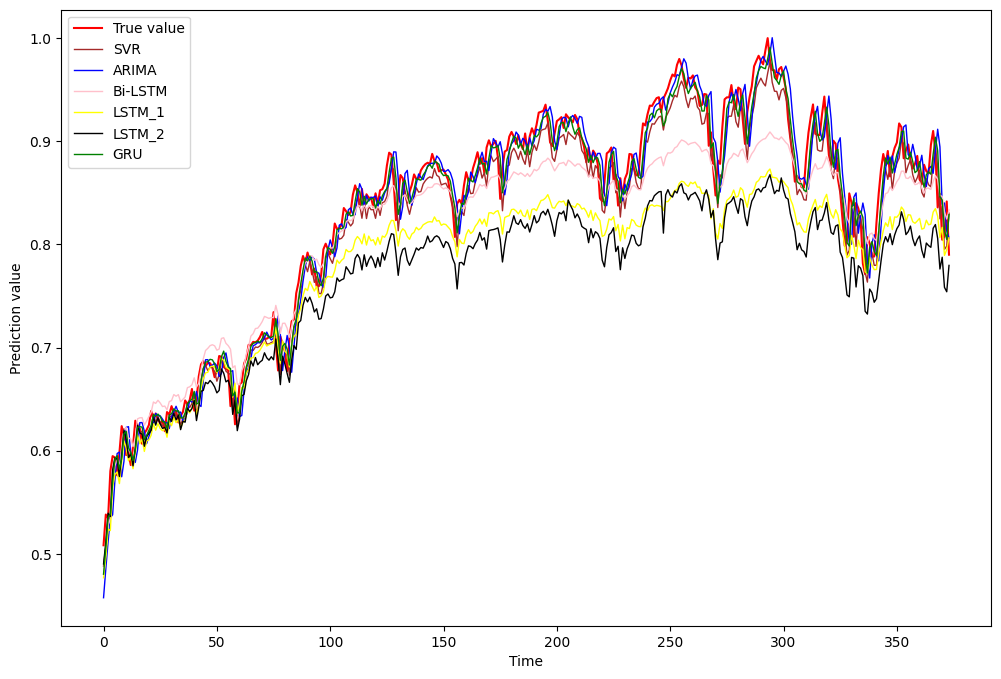

In [268]:
# 모든 모델 그래프
plt.figure(figsize=(12,8))
plt.plot(y_t, label = "True value", color = "red", linewidth=1.5)
plt.plot(svr_pred[29:len(svr_pred)], label= "SVR", color = "brown", linewidth = 1)
plt.plot(arima_pred[29:len(arima_pred)].reset_index(drop=True), label = "ARIMA", color = "blue", linewidth = 1)
plt.plot(bi_lstm_pred, label = "Bi-LSTM", color = "pink", linewidth=1)
plt.plot(lstm_1_pred, label = "LSTM_1", color = "yellow", linewidth=1)
plt.plot(lstm_2_pred[29:len(lstm_2_pred)], label = "LSTM_2", color = "black", linewidth=1)
plt.plot(gru_pred, label = "GRU", color = "green", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Prediction value")
plt.legend()

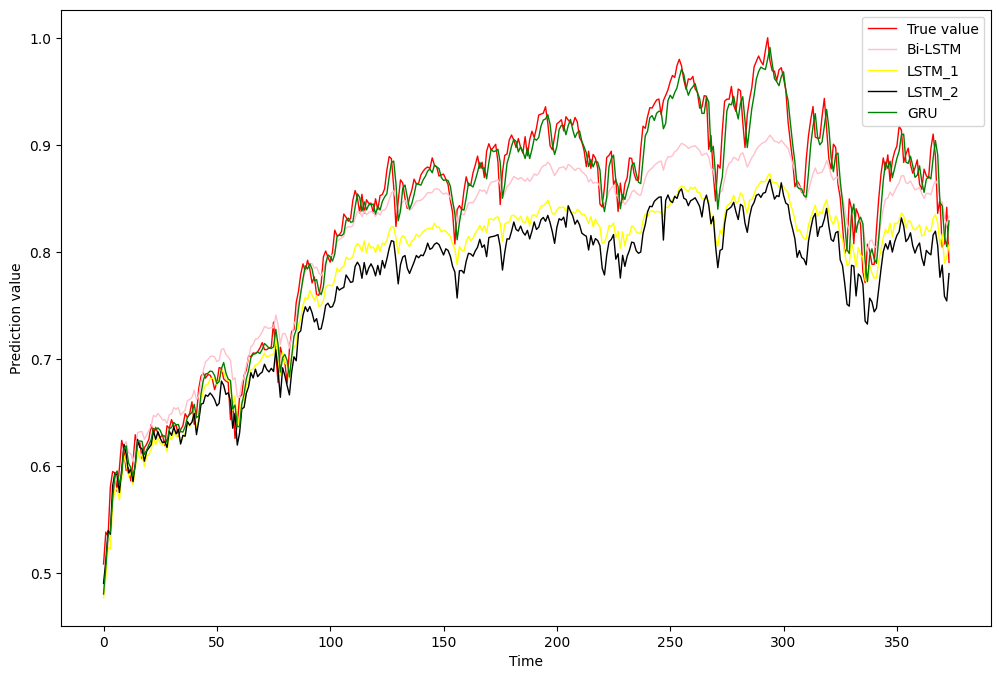

In [270]:
# ARIMA, SVR을 제외한 모델 그래프
plt.figure(figsize=(12,8))
plt.plot(y_t, label = "True value", color = "red", linewidth=1)
plt.plot(bi_lstm_pred, label = "Bi-LSTM", color = "pink", linewidth=1)
plt.plot(lstm_1_pred, label = "LSTM_1", color = "yellow", linewidth=1)
plt.plot(lstm_2_pred[29:len(lstm_2_pred)], label = "LSTM_2", color = "black", linewidth=1)
plt.plot(gru_pred, label = "GRU", color = "green", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Prediction value")
plt.legend()